# Network Analysis

## Libraries

In [5]:
import pandas as pd

df = pd.DataFrame({"hola": ["mundo", "que poas"], "qq": ["pp", "phs"]})
df.unstack().reset_index(drop=False).drop(columns="level_1").rename(columns={"level_0": "edge", 0: "nodes"})

,edge,nodes
0,hola,mundo
1,hola,que poas
2,qq,pp
3,qq,phs


In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
from network_tools import generate_network_relations, get_k_connected_components, get_basic_statistics

pd.set_option("display.max_columns", None)

In [2]:
def generar_coordenadas(num_coordenadas):
    latitudes = []
    longitudes = []

    for _ in range(num_coordenadas):
        # Generar latitud aleatoria dentro de los límites de España
        lat = random.uniform(40, 41)
        latitudes.append(lat)

        # Generar longitud aleatoria dentro de los límites de España
        lon = random.uniform(-4, -3)
        longitudes.append(lon)

    return latitudes, longitudes

## Filter

In [3]:
raw_allowed_edges = pd.read_csv("../data/emt-linea-data-clean.csv")
raw_allowed_edges["from_codigo_estacion"] = raw_allowed_edges["from_codigo_estacion"].astype(str).str.zfill(4)
raw_allowed_edges["to_codigo_estacion"] = raw_allowed_edges["to_codigo_estacion"].astype(str).str.zfill(4)

In [4]:
raw_allowed_edges.tail(3)

,from_codigo_estacion,to_codigo_estacion,edge
11107,1548,0352,U
11108,0352,1545,U
11109,1545,1546,U


In [5]:
raw_data = pd.read_csv("../data/emt-data-clean.csv")
raw_data["codigo_estacion"] = raw_data["codigo_estacion"].astype(str).str.zfill(4)
raw_data["codigo_parada"] = raw_data["codigo_parada"].astype(str).str.zfill(5)
raw_data["cp_parada"] = raw_data["cp_parada"].astype(str)
raw_data["distrito_parada"] = raw_data["distrito_parada"].astype(str)
print(raw_data.shape)

(11104, 7)


In [6]:
## Auxiliar
# aux = raw_data[["codigo_parada"]].drop_duplicates(keep="first")
# latitude, longitude = generar_coordenadas(num_coordenadas=aux.shape[0])
# aux["lat"] = latitude
# aux["lon"] = longitude
aux = pd.read_csv("../data/longitude_latitude.csv")
aux = aux.rename(columns={"longitud": "lon", "latitud": "lat"})
aux["codigo_parada"] = aux["codigo_parada"].astype(str).str.zfill(5)
raw_data = pd.merge(left=raw_data, right=aux, how="inner", on="codigo_parada")
print(raw_data.shape)

(11054, 9)


In [7]:
raw_data["lat_distrito"] = raw_data.groupby(["distrito_parada"])["lat"].transform("mean")
raw_data["lon_distrito"] = raw_data.groupby(["distrito_parada"])["lon"].transform("mean")

raw_data["lat_cp"] = raw_data.groupby(["cp_parada"])["lat"].transform("mean")
raw_data["lon_cp"] = raw_data.groupby(["cp_parada"])["lon"].transform("mean")

In [8]:
from_data = raw_data.copy(deep=True)
to_data = raw_data.copy(deep=True)

from_data.columns = [f"from_{col}" for col in from_data.columns]
to_data.columns = [f"to_{col}" for col in to_data.columns]

In [9]:
net_data = pd.merge(left=from_data, right=to_data, how="inner", left_on="from_linea", right_on="to_linea")
net_data = net_data[net_data["from_codigo_parada"] != net_data["to_codigo_parada"]]
net_data.shape

(623646, 26)

In [10]:
raw_allowed_edges = raw_allowed_edges.rename(columns={
    "edge": "from_linea",
})

In [11]:
net_data = pd.merge(
    left=net_data, 
    right=raw_allowed_edges, 
    how="inner", 
    on=["from_codigo_estacion", "to_codigo_estacion", "from_linea"]
    )
net_data.shape

(11011, 26)

### Bus stops as nodes

In [12]:
net_busstop_data = net_data[net_data["from_codigo_parada"] != net_data["to_codigo_parada"]]
net_busstop_data = net_busstop_data.drop(columns=["to_linea"])
net_busstop_data = net_busstop_data.rename(columns={"from_linea": "edge"})
net_busstop_data.shape

(11011, 25)

### Postal code as nodes

In [13]:
net_cp_data = net_data[net_data["from_cp_parada"] != net_data["to_cp_parada"]]
net_cp_data = net_cp_data.drop(columns=["to_linea"])
net_cp_data = net_cp_data.rename(columns={"from_linea": "edge"})
net_cp_data.shape

(1778, 25)

### Distrito as nodes

In [14]:
net_distrito_data = net_data[net_data["from_distrito_parada"] != net_data["to_distrito_parada"]]
net_distrito_data = net_distrito_data.drop(columns=["to_linea"])
net_distrito_data = net_distrito_data.rename(columns={"from_linea": "edge"})
net_distrito_data.shape

(1047, 25)

## Data graphs

### Distrito

In [15]:
distrito_cols = [
    "from_distrito_parada", "to_distrito_parada", "edge", "from_lat_distrito", "from_lon_distrito", "to_lat_distrito", "to_lon_distrito"
    ]

In [16]:
net_distrito_data_s = net_distrito_data[distrito_cols].drop_duplicates(keep="first")
net_distrito_data_s.shape

(994, 7)

In [17]:
min_lat, max_lat = net_distrito_data_s[["from_lat_distrito", "to_lat_distrito"]].min().min(), net_distrito_data_s[["from_lat_distrito", "to_lat_distrito"]].max().max()
min_lon, max_lon = net_distrito_data_s[["from_lon_distrito", "to_lon_distrito"]].min().min(), net_distrito_data_s[["from_lon_distrito", "to_lon_distrito"]].max().max()

normalize = lambda x, min_x, max_x: (x - min_x) / (max_x - min_x)

In [18]:
net_distrito_data_s["from_lat_distrito"] = net_distrito_data_s["from_lat_distrito"].apply(normalize, args=(min_lat, max_lat))
net_distrito_data_s["from_lon_distrito"] = net_distrito_data_s["from_lon_distrito"].apply(normalize, args=(min_lon, max_lon))
net_distrito_data_s["to_lat_distrito"] = net_distrito_data_s["to_lat_distrito"].apply(normalize, args=(min_lat, max_lat))
net_distrito_data_s["to_lon_distrito"] = net_distrito_data_s["to_lon_distrito"].apply(normalize, args=(min_lon, max_lon))

net_distrito_data_s["n_buses_between"] = net_distrito_data_s.groupby(["from_distrito_parada", "to_distrito_parada"]).transform("size")
net_distrito_data_s["weights"] = net_distrito_data_s["n_buses_between"] / net_distrito_data_s["n_buses_between"].max()

In [19]:
net_distrito_data_s = net_distrito_data_s.rename(columns={
    "from_distrito_parada": "from_node",
    "from_lat_distrito": "from_lat",
    "from_lon_distrito": "from_lon",
    "to_distrito_parada": "to_node",
    "to_lat_distrito": "to_lat",
    "to_lon_distrito": "to_lon",
    "n_buses_between": "n_buses",
    "weights": "weight"
})
net_distrito_data_s.to_csv("../data/net_distrito.csv", index=False)

### CP

In [20]:
cp_cols = [
    "from_cp_parada", "to_cp_parada", "edge", "from_lat_cp", "from_lon_cp", "to_lat_cp", "to_lon_cp"
    ]

In [21]:
net_cp_data_s = net_cp_data[cp_cols].drop_duplicates(keep="first")
net_cp_data_s.shape

(1649, 7)

In [22]:
min_lat, max_lat = net_cp_data_s[["from_lat_cp", "to_lat_cp"]].min().min(), net_cp_data_s[["from_lat_cp", "to_lat_cp"]].max().max()
min_lon, max_lon = net_cp_data_s[["from_lon_cp", "to_lon_cp"]].min().min(), net_cp_data_s[["from_lon_cp", "to_lon_cp"]].max().max()

normalize = lambda x, min_x, max_x: (x - min_x) / (max_x - min_x)

In [23]:
net_cp_data_s["from_lat_cp"] = net_cp_data_s["from_lat_cp"].apply(normalize, args=(min_lat, max_lat))
net_cp_data_s["from_lon_cp"] = net_cp_data_s["from_lon_cp"].apply(normalize, args=(min_lon, max_lon))
net_cp_data_s["to_lat_cp"] = net_cp_data_s["to_lat_cp"].apply(normalize, args=(min_lat, max_lat))
net_cp_data_s["to_lon_cp"] = net_cp_data_s["to_lon_cp"].apply(normalize, args=(min_lon, max_lon))

net_cp_data_s["n_buses_between"] = net_cp_data_s.groupby(["from_cp_parada", "to_cp_parada"]).transform("size")
net_cp_data_s["weights"] = net_cp_data_s["n_buses_between"] / net_cp_data_s["n_buses_between"].max()

In [24]:
net_cp_data_s = net_cp_data_s.rename(columns={
    "from_cp_parada": "from_node",
    "from_lat_cp": "from_lat",
    "from_lon_cp": "from_lon",
    "to_cp_parada": "to_node",
    "to_lat_cp": "to_lat",
    "to_lon_cp": "to_lon",
    "n_buses_between": "n_buses",
    "weights": "weight"
})
net_cp_data_s.to_csv("../data/net_cp.csv", index=False)

### Bus stop

In [25]:
bus_cols = [
    "from_codigo_parada", "to_codigo_parada", "edge", "from_lat", "from_lon", "to_lat", "to_lon"
    ]

In [26]:
net_busstop_data_s = net_busstop_data[bus_cols].drop_duplicates(keep="first")
net_busstop_data_s.shape

(10934, 7)

In [27]:
min_lat, max_lat = net_busstop_data_s[["from_lat", "to_lat"]].min().min(), net_busstop_data_s[["from_lat", "to_lat"]].max().max()
min_lon, max_lon = net_busstop_data_s[["from_lon", "to_lon"]].min().min(), net_busstop_data_s[["from_lon", "to_lon"]].max().max()

normalize = lambda x, min_x, max_x: (x - min_x) / (max_x - min_x)

In [28]:
net_busstop_data_s["from_lat"] = net_busstop_data_s["from_lat"].apply(normalize, args=(min_lat, max_lat))
net_busstop_data_s["from_lon"] = net_busstop_data_s["from_lon"].apply(normalize, args=(min_lon, max_lon))
net_busstop_data_s["to_lat"] = net_busstop_data_s["to_lat"].apply(normalize, args=(min_lat, max_lat))
net_busstop_data_s["to_lon"] = net_busstop_data_s["to_lon"].apply(normalize, args=(min_lon, max_lon))

net_busstop_data_s["n_buses_between"] = net_busstop_data_s.groupby(["from_codigo_parada", "to_codigo_parada"]).transform("size")
net_busstop_data_s["weights"] = net_busstop_data_s["n_buses_between"] / net_busstop_data_s["n_buses_between"].max()

In [29]:
net_busstop_data_s = net_busstop_data_s.rename(columns={
    "from_codigo_parada": "from_node",
    "to_codigo_parada": "to_node",
    "n_buses_between": "n_buses",
    "weights": "weight"
})
net_busstop_data_s.to_csv("../data/net_busstop.csv", index=False)

## Graphs

In [13]:
net_busstop = pd.read_csv("../data/net_busstop.csv")
net_cp = pd.read_csv("../data/net_cp.csv")

In [14]:
net_cp.shape

(1662, 9)

In [1]:
import pandas as pd
busstop = pd.read_csv("../data/net_busstop.csv")
busstop

,from_node,to_node,edge,from_lat,from_lon,to_lat,to_lon,n_buses,weight
0,2522,2524,54,0.326574,0.662925,0.320149,0.663283,2,0.117647
1,2522,3338,142,0.326574,0.662925,0.313324,0.656838,1,0.058824
2,2522,2524,144,0.326574,0.662925,0.320149,0.663283,2,0.117647
3,1748,1746,134,0.874613,0.417157,0.862941,0.418579,1,0.058824
4,2530,2532,54,0.311151,0.681086,0.306375,0.669495,1,0.058824
...,...,...,...,...,...,...,...,...,...
10929,5440,5494,BR1,0.871584,0.775407,0.853617,0.775493,1,0.058824
10930,5435,5433,BR1,0.883424,0.756076,0.883284,0.742373,1,0.058824
10931,5438,5440,BR1,0.883017,0.756858,0.871584,0.775407,1,0.058824
10932,5434,5438,BR1,0.882900,0.743017,0.883017,0.756858,1,0.058824


In [10]:
busstop = pd.read_csv("../data/net_busstop.csv")
latlon = pd.read_csv("../data/longitude_latitude.csv")
emt_csv = pd.read_csv('../data/emt-data-clean.csv')

paradas = list(emt_csv['codigo_parada'].unique())
coor_paradas = list(latlon['codigo_parada'].astype(int))
paradas_faltan = []

for parada in paradas:
    if parada not in coor_paradas:
        paradas_faltan.append(parada)

paradas_faltan

[4498,
 2382,
 3776,
 96,
 1265,
 1263,
 3791,
 3876,
 776,
 577,
 790,
 3777,
 454,
 791,
 4040,
 777,
 1651,
 2800,
 2045,
 2302,
 4475,
 9388,
 5974]

In [14]:
emt_csv.dtypes

codigo_estacion      int64
codigo_parada        int64
nombre_parada       object
linea               object
direccion_parada    object
cp_parada            int64
distrito_parada      int64
dtype: object

In [2]:
from pandas import concat, DataFrame

def generate_graph(dataframe: DataFrame, gtype: str="undirect"):
    """TBD"""
    nodes_a = dataframe[["from_node", "from_lat", "from_lon"]]
    nodes_b = dataframe.drop(columns=["from_node", "from_lat", "from_lon"]).rename(columns={
        "to_node": "from_node",
        "to_lat": "from_lat",
        "to_lon": "from_lon"

    })[["from_node", "from_lat", "from_lon"]]
    nodes = concat([nodes_a, nodes_b]).drop_duplicates(keep="first")
    edges = dataframe[["from_node", "to_node", "weight"]].drop_duplicates(keep="first")
    if gtype == "undirect":
        graph = nx.Graph()
    elif gtype == "direct":
        graph = nx.DiGraph()

    for node in nodes.itertuples():
        graph.add_node(node.from_node, pos=(node.from_lat, node.from_lon))
    for edge in edges.itertuples():
        graph.add_edge(edge.from_node, edge.to_node, weight=edge.weight)
    
    return graph

In [3]:
net_cp = generate_graph(dataframe=net_cp)

NameError: name 'net_cp' is not defined

In [ ]:
nx.is_connected(net_cp)

True

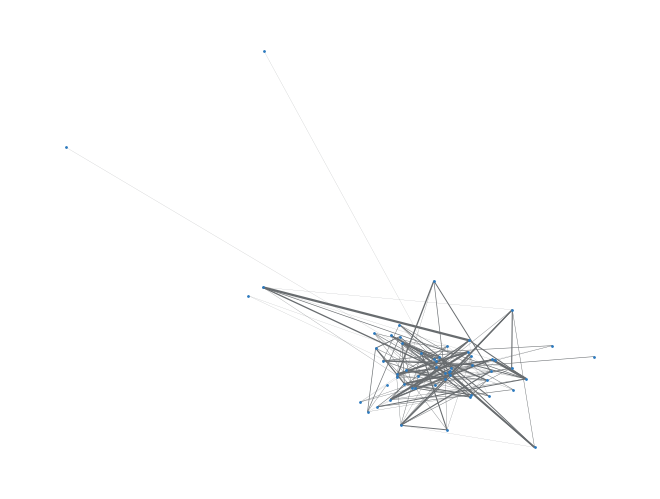

In [ ]:
pos = nx.get_node_attributes(net_cp, "pos")
ww = [net_cp[u][v]["weight"] * 2 for u,v in net_cp.edges()]

nx.draw(
    net_cp, pos, width=ww, 
    with_labels=False, node_color="#2c7abf", font_size=8, 
    node_size=1, edge_color="#686c6f", font_color="#fff", 
    font_weight="bold"
    )
plt.show()

In [ ]:
busstop_graph2 = get_k_connected_components(busstop_graph, k=100)
H = busstop_graph.subgraph(busstop_graph2[0])

In [ ]:
len(busstop_graph2)

2

In [ ]:
distrito_statistics = get_basic_statistics(H)